In [1]:
import pandas as pd

df = pd.read_csv(r"C:\Users\ISMAIMZ\OneDrive - Hapag-Lloyd AG\Documents\Books\Projects\Churn Prediction\archive\customer_churn.csv")

In [2]:
df.columns

Index(['Names', 'Age', 'Total_Purchase', 'Account_Manager', 'Years',
       'Num_Sites', 'Onboard_date', 'Location', 'Company', 'Churn'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Names            900 non-null    object 
 1   Age              900 non-null    float64
 2   Total_Purchase   900 non-null    float64
 3   Account_Manager  900 non-null    int64  
 4   Years            900 non-null    float64
 5   Num_Sites        900 non-null    float64
 6   Onboard_date     900 non-null    object 
 7   Location         900 non-null    object 
 8   Company          900 non-null    object 
 9   Churn            900 non-null    int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 70.4+ KB


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df.drop(columns=['Names', 'Onboard_date'])
df = pd.get_dummies(df, columns=['Location', 'Company'], drop_first=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
num_cols = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92       150
           1       0.58      0.73      0.65        30

    accuracy                           0.87       180
   macro avg       0.76      0.81      0.78       180
weighted avg       0.88      0.87      0.87       180

ROC-AUC: 0.9095555555555556


In [9]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0]/ y_train.value_counts()[1]),
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)
y_proba_xgb = xgb_clf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_xgb))
print("XGBoost ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

C:\Users\ISMAIMZ\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.92      0.93      0.92       150
           1       0.62      0.60      0.61        30

    accuracy                           0.87       180
   macro avg       0.77      0.76      0.77       180
weighted avg       0.87      0.87      0.87       180

XGBoost ROC-AUC: 0.8371111111111111


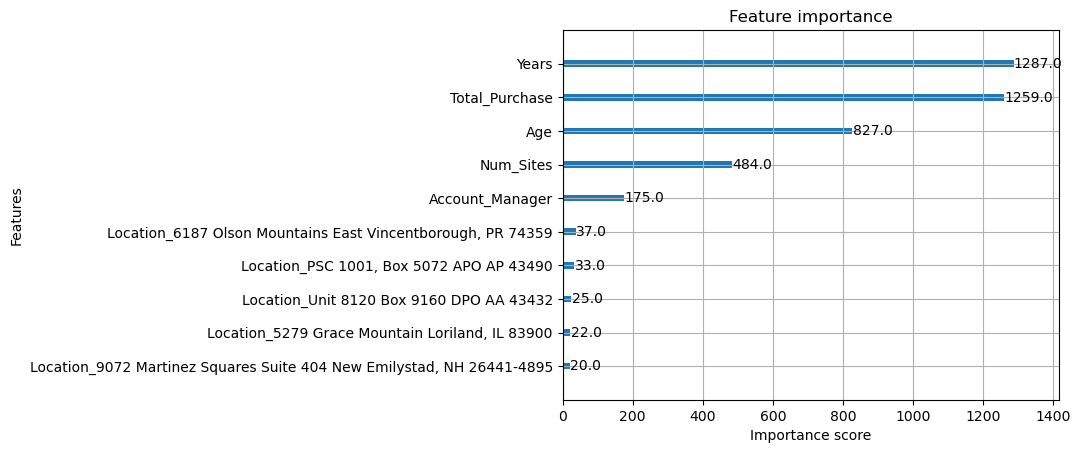

In [13]:
import matplotlib.pyplot as plt

xgb.plot_importance(xgb_clf, max_num_features=10, importance_type='weight')
plt.show()

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

              precision    recall  f1-score   support

           0       0.87      0.99      0.93       150
           1       0.88      0.23      0.37        30

    accuracy                           0.87       180
   macro avg       0.87      0.61      0.65       180
weighted avg       0.87      0.87      0.83       180

Random Forest ROC-AUC: 0.9034444444444444


In [11]:
import pandas as pd

feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
print(feat_importances.sort_values(ascending=False).head(10))

Num_Sites                                                      0.230865
Years                                                          0.088890
Total_Purchase                                                 0.051337
Age                                                            0.042815
Account_Manager                                                0.012275
Location_PSC 1001, Box 5072 APO AP 43490                       0.004865
Location_5279 Grace Mountain Loriland, IL 83900                0.004541
Location_335 Dyer Shoals Port Patricia, PR 84461-1647          0.004295
Company_Taylor-Vaughn                                          0.004223
Location_6187 Olson Mountains East Vincentborough, PR 74359    0.004156
dtype: float64


In [14]:
y_proba_scores = log_reg.predict_proba(X_test)[:,1]

scores = pd.DataFrame({
    'Churn_prob': y_proba_scores,
    'True_label': y_test.values
}, index=X_test.index)

In [15]:
scores

,Churn_prob,True_label
390,0.300846,0
604,0.131794,0
796,0.070222,0
249,0.099287,0
706,0.085638,0
...,...,...
703,0.135343,0
624,0.506702,0
608,0.700427,0
850,0.190850,0


In [17]:
bins = [0.0, 0.25, 0.5, 0.75, 1.0]
labels = ['Low','Medium','High','Very High']

scores['Risk_Tier'] = pd.cut(scores['Churn_prob'], bins=bins, labels=labels, include_lowest=True)
print(scores['Risk_Tier'].value_counts())

Risk_Tier
Low          122
Very High     21
Medium        20
High          17
Name: count, dtype: int64


In [18]:
risk_churn = scores.groupby('Risk_Tier')['True_label'].mean()
print(risk_churn)

Risk_Tier
Low          0.032787
Medium       0.200000
High         0.294118
Very High    0.809524
Name: True_label, dtype: float64


C:\Users\ISMAIMZ\AppData\Local\Temp\ipykernel_17604\1763640488.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_churn = scores.groupby('Risk_Tier')['True_label'].mean()


Most customers are safe (Low risk, 68%), but ignoring the smaller high-risk groups would be costly.

Churn risk escalates sharply: from 3% → 20% → 29% → 81%.

Very High risk customers are the “red zone” — they need immediate, personalized retention strategies.

Medium and High risk tiers are the sweet spot for intervention: they’re still salvageable, unlike many in the Very High group.

## Classic A/B Test Simulation

In [20]:
scores.head(10)

,Churn_prob,True_label,Risk_Tier
390,0.300846,0,Medium
604,0.131794,0,Low
796,0.070222,0,Low
249,0.099287,0,Low
706,0.085638,0,Low
810,0.003615,0,Low
202,0.434829,0,Medium
111,0.026624,1,Low
278,0.003633,0,Low
882,0.002348,0,Low


In [22]:
import numpy as np

np.random.seed(42)
scores['Arm'] = np.random.choice(['Control', 'Treatment'], size=len(scores))

effect = 0.85
scores['Proba_Treated'] = np.where(scores['Arm']=='Treatment', scores['Churn_prob'] * effect, scores['Churn_prob'])

In [23]:
scores.head(10)

,Churn_prob,True_label,Risk_Tier,Arm,Proba_Treated
390,0.300846,0,Medium,Control,0.300846
604,0.131794,0,Low,Treatment,0.112025
796,0.070222,0,Low,Control,0.070222
249,0.099287,0,Low,Control,0.099287
706,0.085638,0,Low,Control,0.085638
810,0.003615,0,Low,Treatment,0.003072
202,0.434829,0,Medium,Control,0.434829
111,0.026624,1,Low,Control,0.026624
278,0.003633,0,Low,Control,0.003633
882,0.002348,0,Low,Treatment,0.001996


In [25]:
threshold = 0.5
scores['Churn_Control'] = (scores['Churn_prob'] > threshold).astype(int)
scores['Churn_Treated'] = (scores['Proba_Treated'] > threshold).astype(int)

In [26]:
control_rate = scores.loc[scores['Arm']=='Control', 'Churn_Control'].mean()
treat_rate = scores.loc[scores['Arm']=='Treatment', 'Churn_Treated'].mean()

uplift = control_rate - treat_rate
print(f"Control Churn: {control_rate:.3f} | Treatment Churn: {treat_rate:.3f} | Uplift: {uplift:.3f}")

Control Churn: 0.221 | Treatment Churn: 0.160 | Uplift: 0.061


## Personalized A/B: target only high-risk

In [28]:
effect = 0.85
scores['Proba_Treated_Personalized'] = scores['Churn_prob']

mask = scores['Risk_Tier'].isin(['Medium','High','Very High'])
scores.loc[mask, 'Proba_Treated_Personalized'] = scores.loc[mask, 'Churn_prob'] * effect

threshold = 0.5
scores['Churn_Treated_Personalized'] = (scores['Proba_Treated_Personalized'] > threshold).astype(int)

control_rates = scores['Churn_Control'].mean()
treat_rate = scores['Churn_Treated_Personalized'].mean()

uplift = control_rate - treat_rate
print(f"Control Churn: {control_rate:.3f} | Treatment Churn: {treat_rate:.3f} | Uplift: {uplift:.3f}")

Control Churn: 0.221 | Treatment Churn: 0.178 | Uplift: 0.043


## Multi‑Armed Bandit Simulation

In [33]:
import numpy as np

arms = {
    'Discount': 0.20,
    'Loyalty': 0.15,
    'PremiumSupport': 0.25
}

n_trails = 1000
rewards = {arm:0 for arm in arms}
counts = {arm:0 for arm in arms}

epsilon = 0.1

for t in range(n_trails):
    if np.random.rand() < epsilon:
        chosen_arm = np.random.choice(list(arms.keys()))
    else:
        chosen_arm = max(rewards, key=lambda x: rewards[x]/(counts[x]+1e-6))

    true_effectiveness = arms[chosen_arm]
    reward = np.random.rand() < true_effectiveness

    counts[chosen_arm] += 1
    rewards[chosen_arm] += reward

for arm in arms:
    avg_reward = rewards[arm] / (counts[arm]+1e-6)
    print(f"{arm}: chosen {counts[arm]} times, avg reward {avg_reward:.3f}")

Discount: chosen 39 times, avg reward 0.154
Loyalty: chosen 38 times, avg reward 0.158
PremiumSupport: chosen 923 times, avg reward 0.267
